# Denoise filter
Xử lý theo MSE LOSS MEL

## Kiểm tra có xử lý đủ số lượng denoise chưa

In [ ]:
concat_audio_path = '/home4/tuanlha/EXpressiveTTS/dataRawProcess/03_concat_audio'
denoised_audio_path=  '/home4/tuanlha/EXpressiveTTS/dataRawProcess/04_denoise'

import os

for playlist in os.listdir(concat_audio_path):
    try:
        playlist_path = os.path.join(concat_audio_path, playlist)
        for episode in os.listdir(playlist_path):
            episode_path = os.path.join(playlist_path, episode)
            for audio in os.listdir(episode_path):
                audio_path = os.path.join(episode_path, audio)
                if audio.endswith('.wav'):
                    denoised_wav_path = os.path.join(denoised_audio_path, playlist, episode, audio)
                    if not os.path.exists(denoised_wav_path):
                        print(f"Loss {denoised_wav_path}")
    except:
        print(f"Error processing playlist: {playlist}")
        continue

#not: episode 49 killed, 32 36 ? don't know

Loss /home4/tuanlha/EXpressiveTTS/dataRawProcess/04_denoise/TheReviewer/32 Khi cuộc đời vứt cho bạn 1 quả mướp đăng, hãy cook món khổ qua  ｜ Tâm Sự Qua Phim #1： Upstream /SPEAKER_00_19.336_742.463.wav
Loss /home4/tuanlha/EXpressiveTTS/dataRawProcess/04_denoise/TheReviewer/36 Như Lai Thiên Thủ Chưởng VS. Súng Lục Quyền ｜ Recap Xàm ： Tân Thiếu Lâm Tự /SPEAKER_01_68.729_773.075.wav
Loss /home4/tuanlha/EXpressiveTTS/dataRawProcess/04_denoise/TheReviewer/36 Như Lai Thiên Thủ Chưởng VS. Súng Lục Quyền ｜ Recap Xàm ： Tân Thiếu Lâm Tự /SPEAKER_01_773.581_776.264.wav
Loss /home4/tuanlha/EXpressiveTTS/dataRawProcess/04_denoise/TheReviewer/36 Như Lai Thiên Thủ Chưởng VS. Súng Lục Quyền ｜ Recap Xàm ： Tân Thiếu Lâm Tự /SPEAKER_01_776.804_804.395.wav
Loss /home4/tuanlha/EXpressiveTTS/dataRawProcess/04_denoise/TheReviewer/45 Thực dân và địa chủ đã áp bức người dân thế nào ｜ Recap Đất Phương Nam (1997) /SPEAKER_00_35.941_1442.725.wav
Loss /home4/tuanlha/EXpressiveTTS/dataRawProcess/04_denoise/TheReview

In [3]:
import librosa
import numpy as np
import os, psutil
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

In [4]:
playlist_name = 'GameCucHay'
raw = f'/home4/tuanlha/EXpressiveTTS/dataRawProcess/03_concat_audio/{playlist_name}'
denoised = f'/home4/tuanlha/EXpressiveTTS/dataRawProcess/04_denoise/{playlist_name}'
dct_mse = {}

In [15]:
def calculate_normalized_mel_mse(audio_raw_path, audio_denoised_path, sr=22050, n_fft=2048, hop_length=512):
    # Load và xử lý audio như trước
    y_raw, _ = librosa.load(audio_raw_path, sr=sr)
    y_denoised, _ = librosa.load(audio_denoised_path, sr=sr)
        
    min_len = min(len(y_raw), len(y_denoised))
    y_raw = y_raw[:min_len]
    y_denoised = y_denoised[:min_len]
    
    # Tính Mel-spectrogram
    mel_raw = librosa.feature.melspectrogram(y=y_raw, sr=sr, n_fft=n_fft, 
                                          hop_length=hop_length)
    mel_denoised = librosa.feature.melspectrogram(y=y_denoised, sr=sr, n_fft=n_fft, 
                                               hop_length=hop_length)
    
    # Chuyển sang dB scale
    mel_raw_db = librosa.power_to_db(mel_raw, ref=np.max)
    mel_denoised_db = librosa.power_to_db(mel_denoised, ref=np.max)
    
    # Tính MSE chuẩn hóa (trung bình trên tất cả các frames và mel bands)
    mse_value = np.mean((mel_raw_db - mel_denoised_db) ** 2)
    print(f'{audio_denoised_path}, MSE: {mse_value}')
    return mse_value

def process_file(args):
    episode_name, file, raw, denoised = args
    try:
        audio_raw_path = os.path.join(raw, episode_name, file)
        audio_denoised_path = os.path.join(denoised, episode_name, file)
        return episode_name, calculate_normalized_mel_mse(audio_raw_path, audio_denoised_path)
    except Exception as e:
        print(f"Error processing {file}: {str(e)}")
        return None

def limit_cpu_for_diarization():
    # return
    """Giới hạn process và các subprocess chỉ chạy trên core 0 và 1"""
    try:
        p = psutil.Process(os.getpid())
        p.cpu_affinity([i for i in range(32, 40)])  # Chỉ dùng core 0 và 1
        print(f"Process {os.getpid()} bị giới hạn trên core: {p.cpu_affinity()}")
    except Exception as e:
        print(f"Không thể thiết lập cpu_affinity: {e}")



In [16]:
MAX_CORES = 2  # Chỉ sử dụng 2 core
dct_mse = {}
cnt = 0
for episode_name in os.listdir(raw):
    print(f"Processing {episode_name}")
    files = [f for f in os.listdir(os.path.join(raw, episode_name)) if f.endswith('.wav')]
    args_list = [(episode_name, file, raw, denoised) for file in files]
    
    with ProcessPoolExecutor(max_workers=MAX_CORES, initializer=limit_cpu_for_diarization) as executor:
        results = list(executor.map(process_file, args_list))
    
    dct_mse[episode_name] = [r[1] for r in results if r is not None]
    cnt +=1
    if cnt>4:
        break

Processing 01 Bản Tin BÓC PHỐT #175 ｜ Game Mới Của Valve Ra Mắt & Chúa Tể Multitasking ｜ GCH News 
Process 29378 bị giới hạn trên core: [32, 33, 34, 35, 36, 37, 38, 39]
Process 29379 bị giới hạn trên core: [32, 33, 34, 35, 36, 37, 38, 39]
/home4/tuanlha/EXpressiveTTS/dataRawProcess/04_denoise/GameCucHay/01 Bản Tin BÓC PHỐT #175 ｜ Game Mới Của Valve Ra Mắt & Chúa Tể Multitasking ｜ GCH News /SPEAKER_01_84.052_86.684.wav, MSE: 43.09775924682617
/home4/tuanlha/EXpressiveTTS/dataRawProcess/04_denoise/GameCucHay/01 Bản Tin BÓC PHỐT #175 ｜ Game Mới Của Valve Ra Mắt & Chúa Tể Multitasking ｜ GCH News /SPEAKER_01_231.37_234.29.wav, MSE: 86.91962432861328
/home4/tuanlha/EXpressiveTTS/dataRawProcess/04_denoise/GameCucHay/01 Bản Tin BÓC PHỐT #175 ｜ Game Mới Của Valve Ra Mắt & Chúa Tể Multitasking ｜ GCH News /SPEAKER_01_0.031_68.358.wav, MSE: 63.40874481201172
/home4/tuanlha/EXpressiveTTS/dataRawProcess/04_denoise/GameCucHay/01 Bản Tin BÓC PHỐT #175 ｜ Game Mới Của Valve Ra Mắt & Chúa Tể Multitasking

In [17]:
import numpy as np

01 Bản Tin BÓC PHỐT #175 ｜ Game Mới Của Valve Ra Mắt & Chúa Tể Multitasking ｜ GCH News 


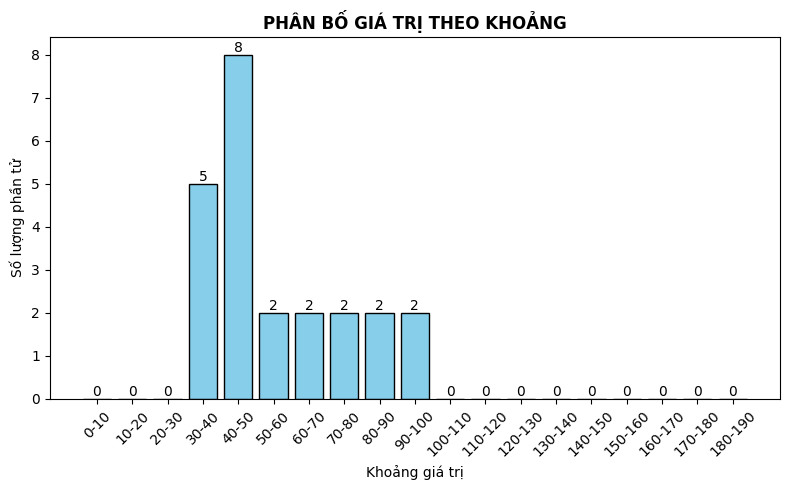

02 Bản Tin BÓC PHỐT #173 ｜ SKIBIDI ＂Đánh Bản Quyền＂ Garry's Mod & Mỳ Tôm Game Thủ ｜ GCH News 


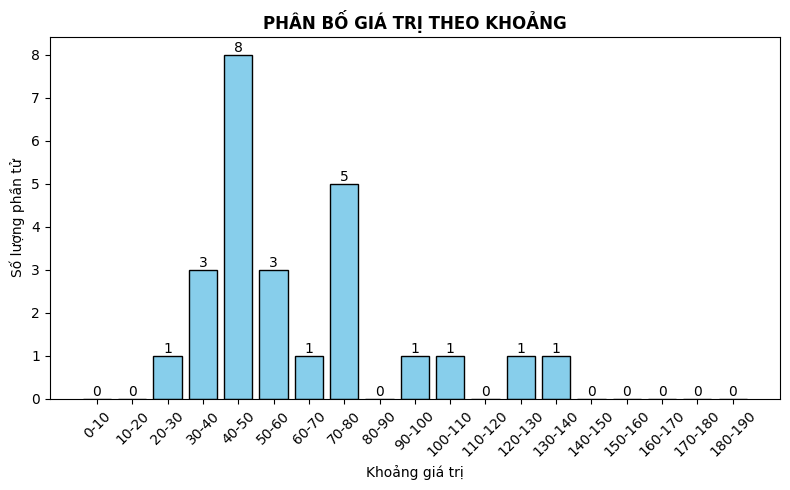

03 Bản Tin BÓC PHỐT #179 ｜ FLAPPY BIRD ＂Hồi Sinh＂ & Nhân Vật Nhiều RULE34 Nhất Deadlock  ｜ GCH News 


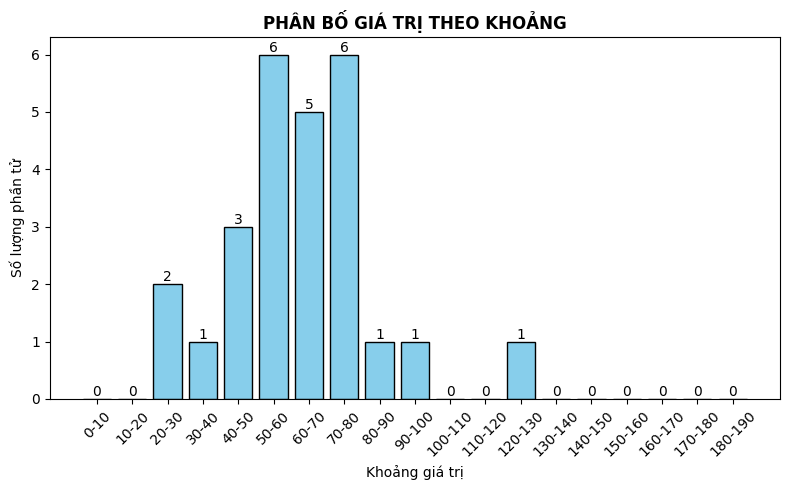

04 Bản Tin BÓC PHỐT #172 ｜ ＂Overwatch＂ Phake Của Sony & Thất Bại Của Capcom ｜ GCH News 


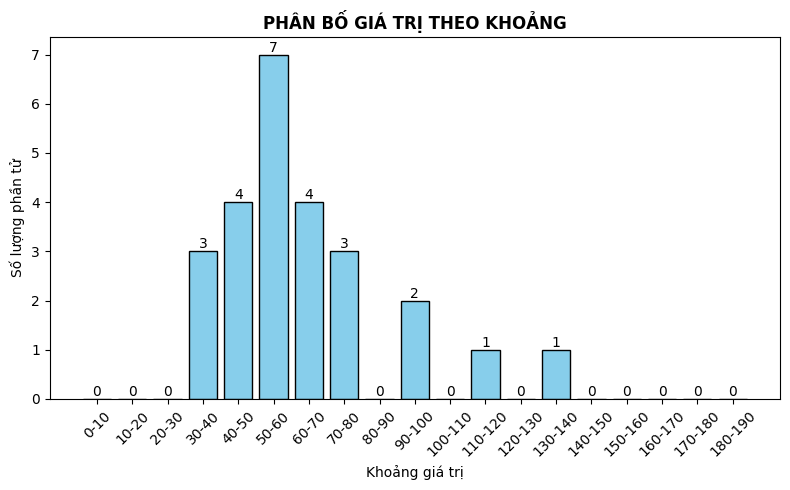

05 Bản Tin BÓC PHỐT #174 ｜ Roblox Lại Bị BÓC PHỐT & HALF-LIFE 3 Lộ Diện？ ｜ GCH News 


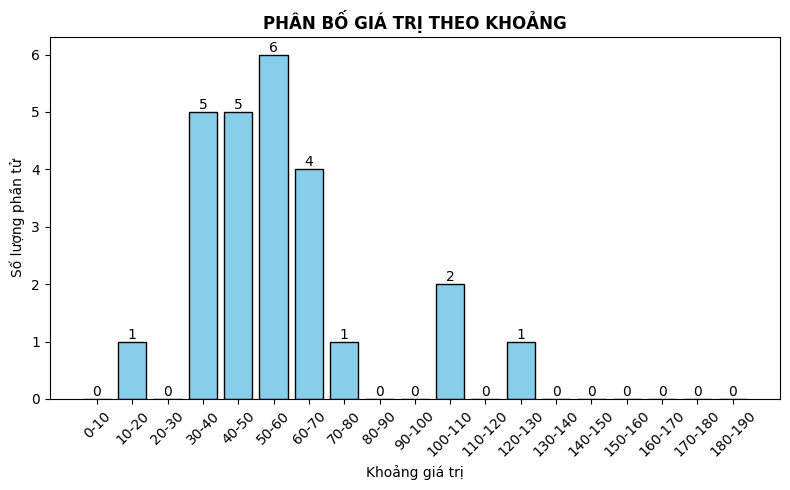

In [18]:
import numpy as np
import matplotlib.pyplot as plt

bins = [10*i for i in range (20)]
def create_bins(data):
    # Đếm số phần tử trong mỗi khoảng
    counts, bin_edges = np.histogram(data, bins=bins)

    # Tạo nhãn cho các khoảng (0-10, 10-20,...)
    bin_labels = [f"{int(bin_edges[i])}-{int(bin_edges[i+1])}" for i in range(len(bin_edges)-1)]

    # Vẽ biểu đồ
    plt.figure(figsize=(8, 5))
    bars = plt.bar(bin_labels, counts, color='skyblue', edgecolor='black')

    # Thêm số lượng lên từng cột
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom')

    plt.title('PHÂN BỐ GIÁ TRỊ THEO KHOẢNG', fontweight='bold')
    plt.xlabel('Khoảng giá trị')
    plt.ylabel('Số lượng phần tử')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

for key in dct_mse:
    print(key)
    create_bins(dct_mse[key])

## Kiểm tra có đủ số lượng audio cần denoise không

In [19]:
import os

In [20]:
raw_folder      = '/home4/tuanlha/EXpressiveTTS/dataRawProcess/03_concat_audio'
denoised_folder = '/home4/tuanlha/EXpressiveTTS/dataRawProcess/04_denoise'
min_step = 10000
for playlist_name in os.listdir(raw_folder):
    raw_playlist = os.path.join(raw_folder, playlist_name)
    denoised_playlist = os.path.join(denoised_folder, playlist_name)
    if not os.path.exists(denoised_playlist):
        continue
    
    print(f"Playlist {playlist_name}:")
    for episode_name in os.listdir(raw_playlist):
        raw_episode = os.path.join(raw_playlist, episode_name)
        denoised_episode = os.path.join(denoised_playlist, episode_name)
        if not os.path.exists(denoised_episode):
            continue
        
        
        loss_file = []
        
        for file in os.listdir(raw_episode):
            if file.endswith('.wav'):
                raw_file = os.path.join(raw_episode, file)
                denoised_file = os.path.join(denoised_episode, file)
                if not os.path.exists(denoised_file):
                    loss_file.append(file)
                    # print(float(file.split('_')[3].split('.')[0])-float(file.split('_')[2]))
                    min_step = min(min_step, float(file.split('_')[3].split('.')[0])-float(file.split('_')[2]))
                    print(min_step)
        if len(loss_file) > 0:
            print(f"  Episode {episode_name}:")
            for file in loss_file:
                print(f"    Missing {file}")


Playlist HaveASip:
Playlist TheReviewer:
722.664
  Episode 32 Khi cuộc đời vứt cho bạn 1 quả mướp đăng, hãy cook món khổ qua  ｜ Tâm Sự Qua Phim #1： Upstream :
    Missing SPEAKER_00_19.336_742.463.wav
704.271
2.4189999999999827
2.4189999999999827
  Episode 36 Như Lai Thiên Thủ Chưởng VS. Súng Lục Quyền ｜ Recap Xàm ： Tân Thiếu Lâm Tự :
    Missing SPEAKER_01_68.729_773.075.wav
    Missing SPEAKER_01_773.581_776.264.wav
    Missing SPEAKER_01_776.804_804.395.wav
2.4189999999999827
  Episode 45 Thực dân và địa chủ đã áp bức người dân thế nào ｜ Recap Đất Phương Nam (1997) :
    Missing SPEAKER_00_35.941_1442.725.wav
2.4189999999999827
2.4189999999999827
2.3710000000000946
2.3710000000000946
2.3710000000000946
2.3710000000000946
2.3710000000000946
2.3710000000000946
2.3710000000000946
2.3710000000000946
2.3710000000000946
1.8330000000000837
1.8330000000000837
  Episode 49 Siêu tổng hợp phim Việt mà chúng tôi đã recap :
    Missing SPEAKER_00_1228.379_2210.065.wav
    Missing SPEAKER_00_2210

In [21]:
min_step

1.8330000000000837

In [27]:
from IPython.display import Audio, display

In [34]:
folder_path = '/home4/tuanlha/EXpressiveTTS/dataRawProcess/05_transcript/TheReviewer/13 Review Phim： Chị Chị Em Em 2 '

In [35]:
#display random 10 audio
import random
import os

files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]
random_files = random.sample(files, 10)
for file in random_files:
    file_path = os.path.join(folder_path, file)
    print(file_path)
    display(Audio(file_path))

/home4/tuanlha/EXpressiveTTS/dataRawProcess/05_transcript/TheReviewer/13 Review Phim： Chị Chị Em Em 2 /SPEAKER_00 - 482.91 - 490.87.wav


/home4/tuanlha/EXpressiveTTS/dataRawProcess/05_transcript/TheReviewer/13 Review Phim： Chị Chị Em Em 2 /SPEAKER_00 - 317.09 - 331.08.wav


/home4/tuanlha/EXpressiveTTS/dataRawProcess/05_transcript/TheReviewer/13 Review Phim： Chị Chị Em Em 2 /SPEAKER_00 - 309.58 - 317.09.wav


/home4/tuanlha/EXpressiveTTS/dataRawProcess/05_transcript/TheReviewer/13 Review Phim： Chị Chị Em Em 2 /SPEAKER_00 - 438.83 - 449.05.wav


/home4/tuanlha/EXpressiveTTS/dataRawProcess/05_transcript/TheReviewer/13 Review Phim： Chị Chị Em Em 2 /SPEAKER_00 - 390.46 - 404.27.wav


/home4/tuanlha/EXpressiveTTS/dataRawProcess/05_transcript/TheReviewer/13 Review Phim： Chị Chị Em Em 2 /SPEAKER_00 - 269.79 - 284.0.wav


/home4/tuanlha/EXpressiveTTS/dataRawProcess/05_transcript/TheReviewer/13 Review Phim： Chị Chị Em Em 2 /SPEAKER_00 - 368.14 - 382.3.wav


/home4/tuanlha/EXpressiveTTS/dataRawProcess/05_transcript/TheReviewer/13 Review Phim： Chị Chị Em Em 2 /SPEAKER_00 - 382.3 - 390.46.wav


/home4/tuanlha/EXpressiveTTS/dataRawProcess/05_transcript/TheReviewer/13 Review Phim： Chị Chị Em Em 2 /SPEAKER_00 - 199.68 - 212.84.wav


/home4/tuanlha/EXpressiveTTS/dataRawProcess/05_transcript/TheReviewer/13 Review Phim： Chị Chị Em Em 2 /SPEAKER_00 - 73.03 - 82.02.wav
